<a href="https://colab.research.google.com/github/IfeanyiEmeagi/Sentiment-Analysis-CETM47/blob/main/Tweet_classification_using_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import re

In [2]:
#Mount the google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#
#Load the dataset
def load_data(file_path):
  """The function loads the dataset from the dataset and print some few informations
  """
  data = pd.read_json(file_path)

  #print some few information about the dataset
  print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.')
  print('It contains the following data type:')
  print(data.dtypes)

  return data

file_path = '/content/drive/MyDrive/Colab Notebooks/CETM47-22_23-AS2-Data.json'
data = load_data(file_path)

The dataset contains 6443 rows and 5 columns.
It contains the following data type:
text                  object
date          datetime64[ns]
label                  int64
id                     int64
label_name            object
dtype: object


In [4]:
#Explore the data
#1. Check for null values
data.isnull().sum() #There is no null values.

text          0
date          0
label         0
id            0
label_name    0
dtype: int64

In [5]:
#2. Check for duplicates
data.duplicated().sum() #There is no dupicate rows.

0

In [6]:
#3. Counts the label_name
data['label_name'].value_counts() #The data is not evenly distributed across the labels.

label_name
pop_culture                 2512
sports_&_gaming             2291
daily_life                   883
science_&_technology         326
business_&_entrepreneurs     287
arts_&_culture               144
Name: count, dtype: int64

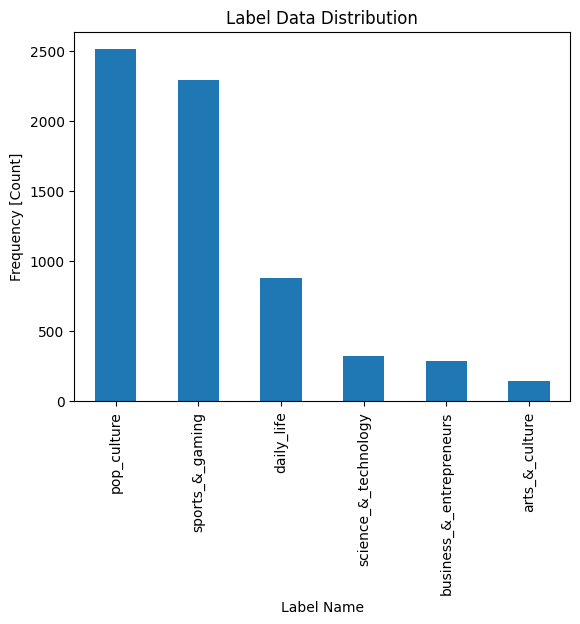

In [7]:
#4. Visualise the distribution.
data['label_name'].value_counts().plot.bar()
plt.xlabel('Label Name')
plt.ylabel('Frequency [Count]')
plt.title('Label Data Distribution');

In [8]:
#5. Extract the label and the label_name
label_match = {label: data.loc[data['label_name'] == label, 'label'].iloc[0] for label in data['label_name'].unique()}
label_match

{'sports_&_gaming': 4,
 'pop_culture': 2,
 'daily_life': 3,
 'business_&_entrepreneurs': 1,
 'science_&_technology': 5,
 'arts_&_culture': 0}

In [9]:
#6. Extract the label and the text

label_text = data[['text', 'label']]
label_text.head(3)

,text,label
0,The {@Clinton LumberKings@} beat the {@Cedar R...,4
1,I would rather hear Eli Gold announce this Aub...,4
2,"Someone take my phone away, I’m trying to not ...",4


In [14]:
#The label is the y and the x is the text.
#7. Extract the text for further processing
texts = label_text['text'].to_list()
texts[:3]

['The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division finals. Evan Edwards hit a 2-run HR. WP Josh Roberson: 5 IP, 3 H, 0 R, 0 BB, 10 K #MWLplayoffs #MWLscoreboard',
 'I would rather hear Eli Gold announce this Auburn game than these dumbasses. {@ESPN@}',
 'Someone take my phone away, I’m trying to not look at {@Chicago Blackhawks@} home game tickets in October ']

In [13]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn

In [12]:
#Download the required modules
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [16]:
#8. Clean the text: Removing whitespace, non alphabetical characters, stop words, tokenize and implement lemmatization.

def lemmatizer_func(word):
  lemmatizer = WordNetLemmatizer()
  mapping = {'N': wn.NOUN, 'V': wn.VERB, 'R': wn.ADV,'J': wn.ADJ}
  pos_tags = pos_tag([word])
  wn_pos_tags = [(word, mapping.get(tag[0].upper(), wn.NOUN)) for (word, tag) in pos_tags]
  word = wn_pos_tags[0][0]
  tag = wn_pos_tags[0][1]
  return lemmatizer.lemmatize(word, tag)



def text_cleaning(texts):
  """The function removes whitespaces, non alphabetical characters, stop words, tokenize and lemmatize the tokens.
  """
  #data cleaning
  texts = re.sub(r'\s+', ' ', texts, flags=re.I) #remove extra spaces from the text
  texts = re.sub(r'\W', ' ', str(texts)) #remove all the special characters
  texts = re.sub(r'\s+[a-zA-Z]\s+', ' ', texts) #remove all single characters
  texts = re.sub(r'\[^a-zA-Z\s]', '', texts)  #remove all characters that is not alphabetical

  #Lower the text
  texts = texts.lower()

  #tokenise the texts
  tokenised_texts = word_tokenize(texts)

  #lemmatize the word
  lemmatized_words = [lemmatizer_func(word) for word in tokenised_texts]

  #remove stop words
  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in lemmatized_words if word not in stop_words]

  #remove words whose length is 3 and below
  filtered_words = [word for word in filtered_words if len(word) > 3]

  #get the index of the unique words
  indices = np.unique(filtered_words, return_index=True)[1]

  clean_text = np.array(filtered_words)[np.sort(indices)].tolist()

  return clean_text

clean_text = [text_cleaning(texts=text) for text in texts]

In [18]:
print(clean_text[:3])

[['clinton', 'lumberkings', 'beat', 'cedar', 'rapid', 'kernel', 'game', 'western', 'division', 'final', 'evan', 'edward', 'josh', 'roberson', 'mwlplayoffs', 'mwlscoreboard'], ['would', 'rather', 'hear', 'gold', 'announce', 'auburn', 'game', 'dumbass', 'espn'], ['someone', 'take', 'phone', 'away', 'look', 'chicago', 'blackhawks', 'home', 'game', 'ticket', 'october']]


In [21]:
from sklearn.model_selection import train_test_split

#Get the labels
y = label_text['label'].to_list()

#Split the test into train and set and ensure the percentage of each label is maintained on train and test set
X_train, X_test, y_train, y_test = train_test_split(clean_text, y, test_size=0.1, stratify=y, random_state=42)

print(f'The X_train conatins {len(X_train)} rows')
print(f'The y_train conatins {len(y_train)} rows')
print(f'The X_test conatins {len(X_test)} rows')
print(f'The y_test conatins {len(y_test)} rows')

The X_train conatins 5798 rows
The y_train conatins 5798 rows
The X_test conatins 645 rows
The y_test conatins 645 rows


In [22]:
#Check for the max length in both X_train and X_test
train_max_length = max([len(row) for row in X_train])
test_max_length = max([len(row) for row in X_test])
print(f'The X_train max length is {train_max_length} and the X_test max length is {test_max_length}.')


The X_train max length is 30 and the X_test max length is 30.


In [23]:
#Convert the X_train and X_test to numerical vectors

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#set an arbitary maximum vocabulary
max_vocab = 100000
tokenizer = Tokenizer(num_words=max_vocab) #Instantiate the tokenizer
tokenizer.fit_on_texts(X_train)

actual_vocab_size  = len(tokenizer.word_index)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#Padd the Sequences to have same length
maxlen = 50 #Since our max length is 30, let set it Sequence length to 50 to factor in expansion a caused by variability for new data.

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print(X_train[:3], X_test[:3])


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 5770 5771    6   11 5772
  2933 5773   33 5774 1238 1116 2934    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0 5775    1 1988  206  327   30
    23  771    2   25  100  650   42  101]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  277 2378  651 1989 3814 2379 1724
   296   51   43 5776  278 1348   23 1349]] [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0   199   315   407   132    38   253  1622


In [24]:
#Convert the y labels to categorical data type
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [25]:
#Build the model

from tensorflow.keras.layers import Embedding, Dropout, Dense, GRU, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam


In [39]:
D = maxlen #The dimension of the feature length
v = actual_vocab_size #The number of unique words

def build_model(v, D):
  """The function builds the model
  Parameters:
  Input: v: the vocabulary size, D: the dimension of the feature dataset

  Return: model
  """
  input_shape = Input(shape=(D,))
  x = Embedding(v+1, D)(input_shape) #v+1 is the number unique words + unknown vocabulary
  x = Bidirectional(GRU(200))(x) #Creates a bidirectional GRU layer with 200 units in both direction.
                                  #The process the input sequences in both direction and concatenates the output to capture the future and past context.

  x = Dense(32, activation='ReLU')(x) #Add a fully connected layer with 32 units and a ReLU activation for feature extractions.
  x = Dropout(0.5)(x) # set 50 percent of the output weights to zero to avoid overfitting
  x = Dense(16, activation='ReLU')(x)
  x = Dense(6, activation='softmax')(x)  #Adds 6 dense layers(fully connected,) and softmax activation for the classification tasks (6 labels). The softmax
                                    # outputs a probability distribution across the 6 labels

  model = Model(input_shape, x)

  return model


def train_model(X_train, y_train, X_test, y_test, learning_rate=0.0001, epoch=100):
  """The function trains the model.
  """
  model = build_model(v, D)

  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=epoch, validation_data = (X_test, y_test))

  return history, model

#history, _ = train_model(X_train, y_train, X_test, y_test)


In [42]:
# visualize the train and validation loss and accuracy

import matplotlib.pyplot as plt

def plot_loss_acc(history):

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  return None

In [45]:
history, model= train_model(X_train, y_train, X_test, y_test, epoch=8, learning_rate=0.001)

Epoch 1/8
182/182 [==============================] - 56s 277ms/step - loss: 1.3487 - accuracy: 0.3981 - val_loss: 1.1091 - val_accuracy: 0.4574
Epoch 2/8
182/182 [==============================] - 50s 273ms/step - loss: 0.8197 - accuracy: 0.6690 - val_loss: 0.7242 - val_accuracy: 0.7318
Epoch 3/8
182/182 [==============================] - 50s 275ms/step - loss: 0.5002 - accuracy: 0.8158 - val_loss: 0.7794 - val_accuracy: 0.7349
Epoch 4/8
182/182 [==============================] - 51s 282ms/step - loss: 0.3926 - accuracy: 0.8529 - val_loss: 0.9377 - val_accuracy: 0.7302
Epoch 5/8
182/182 [==============================] - 49s 265ms/step - loss: 0.3114 - accuracy: 0.8813 - val_loss: 1.0327 - val_accuracy: 0.7473
Epoch 6/8
182/182 [==============================] - 48s 263ms/step - loss: 0.2445 - accuracy: 0.8979 - val_loss: 1.1234 - val_accuracy: 0.7380
Epoch 7/8
182/182 [==============================] - 48s 263ms/step - loss: 0.1908 - accuracy: 0.9200 - val_loss: 1.1969 - val_accuracy:

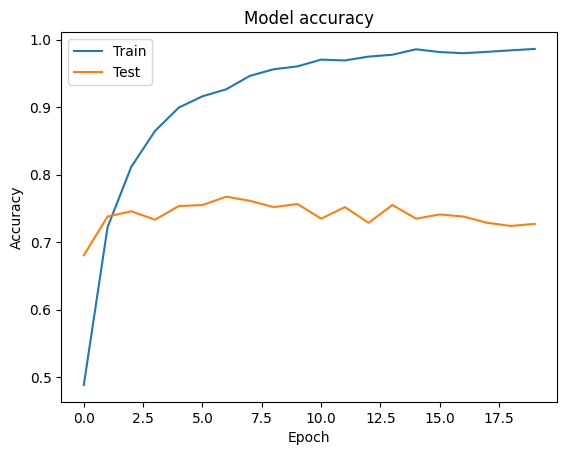

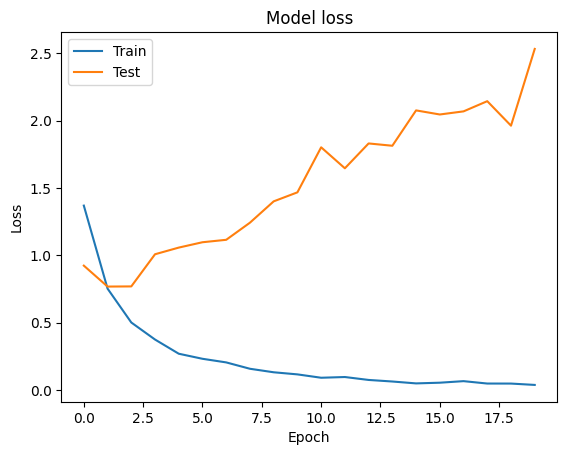

In [44]:
#Visualise the confusion matrix plot.
plot_loss_acc(hmodel)

In [ ]:
#Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'The loss is {loss:.2f}')
print(f'The accuracy is {accuracy:.2f}')

In [ ]:
: